In [67]:
%load_ext autoreload
%autoreload 2

import sys, importlib, pickle, gc
sys.path.append('../..')
sys.modules['src.simulation'] = importlib.import_module('src.logit_graph.simulation')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.logit_graph.graph as graph
import src.logit_graph.logit_estimator as estimator
import src.logit_graph.utils as utils
import src.logit_graph.model_selection as model_selection
import src.logit_graph.gic as gic
import src.logit_graph.param_estimator as pe
import src.logit_graph.graph as graph
import src.logit_graph.model_selection as ms

from src.logit_graph.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [69]:
data_directory = f'../../data/twitch/'
os.listdir(data_directory)

['RU',
 'ENGB',
 'citing.txt',
 'PTBR',
 'DE',
 'README.txt',
 'FR',
 'ES',
 'graphs_processed']

In [70]:
from src.logit_graph.simulation import estimate_sigma_many

# Configuration
an_d = 1  # set the desired d

n_repeats = 50

max_edges = None
max_non_edges = None

l1_wt = 1 # The L1 weight for the regularization
alpha = 0 # The regularization parameter

seed = 42

# Collect Twitch processed graph files
graphs_processed_dir = os.path.join(data_directory, 'graphs_processed')
region_files = [f for f in os.listdir(graphs_processed_dir) if f.endswith('_graph.edges')]
region_files = sorted(region_files)


In [71]:
records = []
#files_to_analyse = region_files[-2:]
files_to_analyse = region_files[::-1]
print(files_to_analyse)

for file_name in files_to_analyse:
    region = file_name.replace('_graph.edges', '')
    file_path = os.path.join(graphs_processed_dir, file_name)
    print(f"Estimating sigmas for region={region} from {file_path}")

    G = nx.read_edgelist(file_path, nodetype=int)
    sigmas = estimate_sigma_many(
        G,
        d=an_d,
        n_repeats=n_repeats,
        max_edges=max_edges,
        max_non_edges=max_non_edges,
        l1_wt=l1_wt,
        alpha=alpha,
        seed=seed,
        verbose=False,
    )

    for idx, s in enumerate(sigmas):
        records.append({
            'region': region,
            'd': an_d,
            'repeat_index': idx,
            'sigma': float(s),
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
        })

['RU_graph.edges', 'PTBR_graph.edges', 'FR_graph.edges', 'ES_graph.edges', 'ENGB_graph.edges', 'DE_graph.edges']
Estimating sigmas for region=RU from ../../data/twitch/graphs_processed/RU_graph.edges


100%|██████████| 50/50 [11:28<00:00, 13.78s/it]


Estimating sigmas for region=PTBR from ../../data/twitch/graphs_processed/PTBR_graph.edges


100%|██████████| 50/50 [04:07<00:00,  4.95s/it]


Estimating sigmas for region=FR from ../../data/twitch/graphs_processed/FR_graph.edges


100%|██████████| 50/50 [48:30<00:00, 58.22s/it]


Estimating sigmas for region=ES from ../../data/twitch/graphs_processed/ES_graph.edges


100%|██████████| 50/50 [18:41<00:00, 22.43s/it]


Estimating sigmas for region=ENGB from ../../data/twitch/graphs_processed/ENGB_graph.edges


100%|██████████| 50/50 [19:16<00:00, 23.12s/it]


Estimating sigmas for region=DE from ../../data/twitch/graphs_processed/DE_graph.edges


100%|██████████| 50/50 [1:38:39<00:00, 118.39s/it]


In [72]:
sigma_df = pd.DataFrame(records)
run_dir = 'runs'
os.makedirs(run_dir, exist_ok=True)
out_path = os.path.join(run_dir, f'twitch_sigma_estimates_d{an_d}_N{n_repeats}.csv')
sigma_df.to_csv(out_path, index=False)
print(f"Saved sigma estimates to {out_path}")
sigma_df.head()


Saved sigma estimates to runs/twitch_sigma_estimates_d1_N50.csv


,region,d,repeat_index,sigma,num_nodes,num_edges
0,RU,1,0,-1.757861,4385,37304
1,RU,1,1,-1.762314,4385,37304
2,RU,1,2,-1.767284,4385,37304
3,RU,1,3,-1.752017,4385,37304
4,RU,1,4,-1.758021,4385,37304


In [79]:
'finish simulation'

'finish simulation'

## running the anova

In [134]:
import os
import pandas as pd
from scipy import stats

# Match the save path used in the dataset notebook
an_d = [0, 1]
n_repeats = 50
run_dir = os.path.join('runs')


dfs = []
for an_d in [0, 1]:
    filename = f'twitch_sigma_estimates_d{an_d}_N{n_repeats}.csv'
    path = os.path.join(run_dir, filename)
    print(f"Loading: {path}")
    df = pd.read_csv(path)
    dfs.append(df)

Loading: runs/twitch_sigma_estimates_d0_N50.csv
Loading: runs/twitch_sigma_estimates_d1_N50.csv


In [135]:
df = pd.concat(dfs)
#subset = df[df['d'] == an_d].copy()

In [136]:
df.head()

,region,d,repeat_index,sigma,num_nodes,num_edges
0,RU,0,0,-1.752862,4385,37304
1,RU,0,1,-1.785105,4385,37304
2,RU,0,2,-1.765568,4385,37304
3,RU,0,3,-1.765380,4385,37304
4,RU,0,4,-1.793135,4385,37304


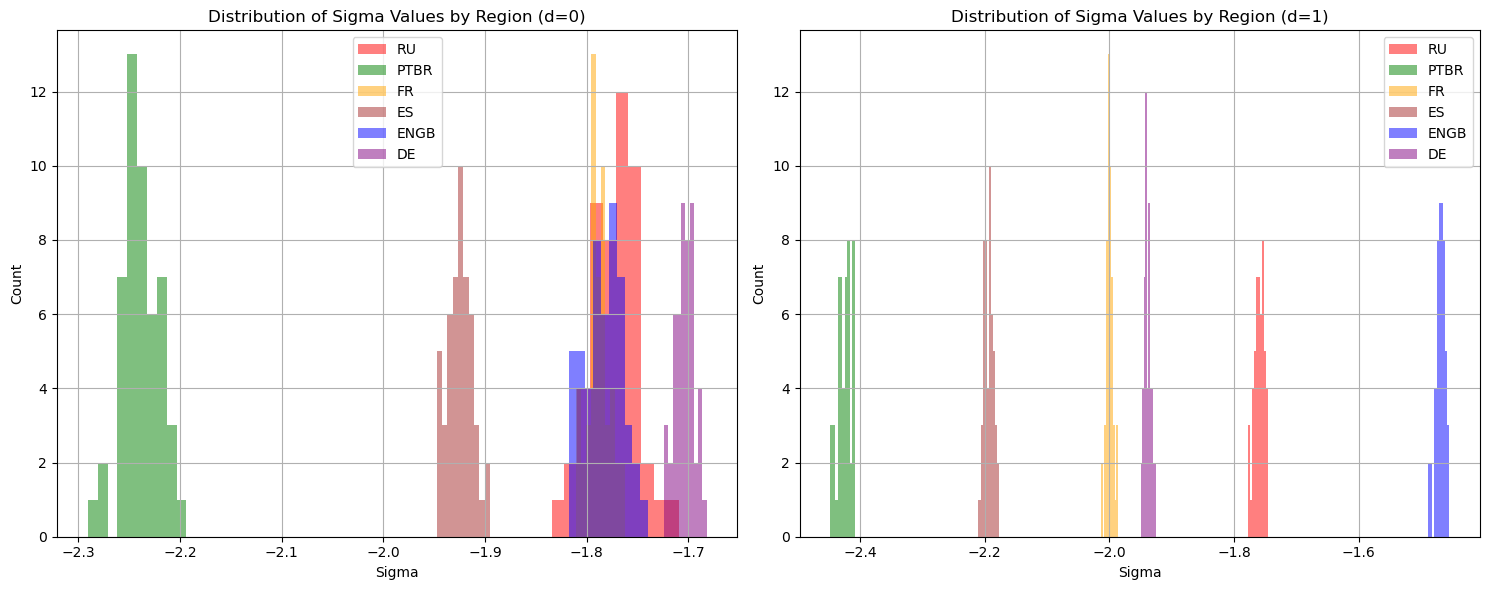

In [137]:
# Create histogram of sigmas by region and d
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for each region
region_colors = {
    'RU': 'red',
    'ENGB': 'blue', 
    'PTBR': 'green',
    'DE': 'purple',
    'FR': 'orange',
    'ES': 'brown'
}

# Plot d=0 data
for region in df['region'].unique():
    region_data = df[(df['region'] == region) & (df['d'] == 0)]['sigma']
    ax1.hist(region_data, alpha=0.5,
            color=region_colors[region],
            label=region,
            bins=10)

#ax1.set_yscale('log')
ax1.set_xlabel('Sigma')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of Sigma Values by Region (d=0)')
ax1.legend()
ax1.grid(True)

# Plot d=1 data
for region in df['region'].unique():
    region_data = df[(df['region'] == region) & (df['d'] == 1)]['sigma']
    ax2.hist(region_data, alpha=0.5,
            color=region_colors[region], 
            label=region,
            bins=10)

#ax2.set_yscale('log')
ax2.set_xlabel('Sigma')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of Sigma Values by Region (d=1)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


In [139]:
# Prepare groups by region and d
groups = df.groupby(['region', 'd'])['sigma'].apply(list)
regions = list(groups.index)

In [148]:
for d in df['d'].unique():
    values = [groups[r] for r in regions if r[1] == d]
    print(len(values), len(values[0]))







    F, p = stats.f_oneway(*values)
    print(f"ANOVA results (d={d}, N={n_repeats}): F={F:.4e}, p={p:.6e}")

6 50
ANOVA results (d=0, N=50): F=7.2854e+03, p=8.563938e-306
6 50
ANOVA results (d=1, N=50): F=9.3508e+04, p=0.000000e+00


In [151]:
# quick summary per region and d
summary = df.groupby(['region', 'd'])['sigma'].agg(['mean', 'std', 'count'])
display(summary)


mean       std  count
region d                           
DE     0 -1.703793  0.009422     50
       1 -1.938634  0.005627     50
ENGB   0 -1.783511  0.018528     50
       1 -1.468537  0.007519     50
ES     0 -1.924475  0.011984     50
       1 -2.193535  0.008022     50
FR     0 -1.788165  0.011333     50
       1 -1.999533  0.005420     50
PTBR   0 -2.239080  0.018234     50
       1 -2.425632  0.010593     50
RU     0 -1.773010  0.023052     50
       1 -1.759796  0.007869     50

In [152]:
# Get summary for d=1 and sort by mean sigma value
summary_sorted = df[df['d']==1].groupby('region')['sigma'].agg(['mean', 'std', 'count']).sort_values('mean', ascending=False)
display(summary_sorted)


,mean,std,count
region,,,
ENGB,-1.468537,0.007519,50
RU,-1.759796,0.007869,50
DE,-1.938634,0.005627,50
FR,-1.999533,0.005420,50
ES,-2.193535,0.008022,50
PTBR,-2.425632,0.010593,50


### Ranking by baseline link tendency (highest to lowest)
- ENGB (mean σ≈−1.47) → higher baseline linking
- RU (≈−1.76)
- DE (≈−1.94)
- FR (≈−2.00)
- ES (≈−2.19)
- PTBR (≈−2.43) → lower baseline linking

In [154]:
'finish all analysis'

'finish all analysis'